In [28]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms 
from torchvision import datasets
import numpy as np 
import pandas as pd
import build_model as build
import os
import cv2
import json
import matplotlib.pyplot as plt
import torchvision.models as models
import build_model as build

print(torch.__version__)

2.0.1+cu118


In [8]:
# Number of parameters at stage 4 Swin Transformer
calc = 0
for i in models.swin_t().features[6:].parameters():
    calc += i.sum()

print(f"Swin Transformer - Stage 4 params : {calc:.4f}")

device = torch.device('cuda')
model = build.buildSparseSwin(
        image_resolution=224,
        swin_type='tiny', 
        num_classes=100, 
        ltoken_num=49, 
        ltoken_dims=512, 
        num_heads=16, 
        qkv_bias=True,
        lf=2, 
        attn_drop_prob=.0, 
        lin_drop_prob=.0, 
        freeze_12=False,
        device=device)

calc = 0
for i in model.step4.parameters():
    calc += i.sum()

print(f"SparTa Block params: {calc:.4f}")

Swin Transformer - Stage 4 params : 4575.6250
SparTa Block params: 2101.7261


In [15]:
import torch
from ptflops import get_model_complexity_info

for sparse_swin_type in ['tiny', 'small', 'base']:
    print(f"SparseSwin-{sparse_swin_type}")
    with torch.cuda.device(0):
        net =  getModel(sparse_swin_type=sparse_swin_type, num_classes=100)
        # net = models.swin_t()
        flops, params = get_model_complexity_info(net, (3, 224, 224), 
                                                    as_strings=False, print_per_layer_stat=False, 
                                                    flops_units='GMac', output_precision=4)
        print(f'GFlops:  {2 * flops * 1e-9:.2f}')
        print(f'Params: {params * 1e-6:.2f} M')
        print()

SparseSwin-tiny
GFlops:  6.22
Params: 20.29 M

SparseSwin-small
GFlops:  7.78
Params: 29.07 M

SparseSwin-base
GFlops:  10.40
Params: 41.00 M



## CIFAR-10 and CIFAR-100

In [16]:
# Dataset Config -------------------------------------------
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transform = {
    'train': transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.Normalize(mean, std)
            ]), 
    'val': transforms.Compose([
                transforms.ToTensor(), 
                transforms.Resize((224, 224), antialias=None),
                transforms.Normalize(mean, std)
            ])
}

status = True
batch_size = 5
dataset_name, dataset_classes = 'cifar10', 10
val_dataset = datasets.CIFAR10(
                    root='./datasets/torch_cifar10/', 
                    train=False, 
                    transform=data_transform['val'], 
                    download=status)

# dataset_name, dataset_classes = 'cifar100', 100
# val_dataset = datasets.CIFAR100(
#                 root='./datasets/torch_cifar100/', 
#                 train=False, 
#                 transform=data_transform['val'], 
#                 download=status)

torch.random.manual_seed(42)
val_loader = torch.utils.data.DataLoader(
                val_dataset, 
                batch_size=batch_size,
                shuffle=True
            )

class2idx = val_dataset.class_to_idx
idx2class = {class2idx[i]: i for i in val_dataset.class_to_idx.keys()}

loader_iterate = iter(val_loader)

Files already downloaded and verified


In [17]:
sample_data, sample_labels = next(loader_iterate)

In [18]:
saved_model_paths = [
    'SparseSwin.pt',
    'SparseSwin_l1_1e-4.pt',
    'SparseSwin_l1_1e-5.pt',
    'SparseSwin_l2_1e-4.pt',
    'SparseSwin_l2_1e-5.pt',
]

In [19]:
def getHeatMap(heatmap):

    h_shape, w_shape = 224, 224

    h_min, h_max = heatmap.min(), heatmap.max()
    norm_map = 255 * ((heatmap - h_min) / (h_max - h_min))
    norm_map = np.uint8(norm_map)
    norm_map = cv2.resize(norm_map, (h_shape, w_shape)) 
    
    norm_map = cv2.applyColorMap(255 - norm_map, cv2.COLORMAP_JET)
    norm_map = np.uint8(norm_map)

    return norm_map

In [7]:
device = torch.device('cpu')

def getModel(sparse_swin_type, num_classes): 
    sparse_swin_type = sparse_swin_type.lower()
    if sparse_swin_type == 'tiny':
        ltoken_num, ltoken_dims = 49, 512
    elif sparse_swin_type == 'small':
        ltoken_num, ltoken_dims = 64, 768
    elif sparse_swin_type == 'base':
        ltoken_num, ltoken_dims = 81, 1024
    else:
        print(f"Unknown SparseSwin Model..")
        return None
    
    model = build.buildSparseSwin(
            image_resolution=224,
            swin_type='tiny', 
            num_classes=num_classes, 
            ltoken_num=ltoken_num, 
            ltoken_dims=ltoken_dims, 
            num_heads=16, 
            qkv_bias=True,
            lf=2, 
            attn_drop_prob=.0, 
            lin_drop_prob=.0, 
            freeze_12=False,
            device=device)

    return model

In [ ]:
for saved_path in saved_model_paths:
    print(saved_path)
    
    #Todo: Model preparation
    model = getModel(sparse_swin_type='tiny', num_classes=dataset_classes)
    im2fmap = nn.Sequential(model.swin_model, model.step4)

    model.load_state_dict(torch.load(f'./SavedModel/{dataset_name}/{saved_path}'))
    
    #Todo: Model test
    model.eval()
    logits, attn_weight1, origin = model(sample_data.to(device))
    heatmaps = []

    activations, attn_weight2, origin = im2fmap(sample_data.to(device))

    # get model preds
    pred = logits.max(-1)[-1]
    model.zero_grad()
    # compute gradients with respect to model's most confident logit
    logits[0, pred].mean().backward(retain_graph=True)
        
    # Get the gradients at the required featuremap location and take avg gradient
    pooled_grads = model.step4.convert_token.convert.weight.data.mean((1, 2, 3))
    # print(pooled_grads.shape)

    # multiply each activation map with
    # corresponding gradient average

    for i in range(activations.shape[2]): 
        origin[:, i, :, :] *= pooled_grads[i]

    heatmap = torch.mean(origin, dim=1).cpu().detach()
    
    inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
                    )
    inv_tensor = inv_normalize(sample_data)
    
    show_idx = 0
    sample_predics = torch.argmax(logits, dim=-1)

    for show_idx in range(batch_size):
        viz_heatmap = getHeatMap(heatmap[show_idx])
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.75))
        
        name_tmp = saved_path.split('_')

        # if name_tmp[2] == 'None':
        #     name = f"{name_tmp[0]}"
        # else:
        #     name = f"{name_tmp[0]} with {name_tmp[2].upper()} ({'1e-4' if name_tmp[4] == '0.0001' else '1e-5'})"
            
        
        name = f"SparseSwin"
        
        if len(name_tmp) > 1:
            lmb_use = name_tmp[1]
            lbd_value = name_tmp[2][:4]
            name += f" with {lmb_use.upper()} ({lbd_value})"
        
        fig.suptitle(name, fontsize=18, color='orange')
        
        temp_inv_tensor = inv_tensor[show_idx].permute(1, 2, 0)
        
        ax[0].set_title(f'Ground Truth: { idx2class[sample_labels[show_idx].item()] }')
        ax[1].set_title(f'Grad-CAM')
        ax[2].set_title(f'Prediction: { idx2class[sample_predics[show_idx].item()] }')
        
        ax[0].imshow(temp_inv_tensor)
        ax[1].imshow(viz_heatmap)
        ax[2].imshow(temp_inv_tensor + ((viz_heatmap/255)*0.35))
        
        plt.show()
        # plt.savefig(f'./gradcam/{dataset_name}/{name}_{show_idx}.png')
    
    
    del model

## ImageNet-100


In [23]:
class Imagenet100(torch.utils.data.Dataset):
    """Some Information about Imagenet100"""
    def __init__(self, df, class2idx, transform):
        super(Imagenet100, self).__init__()
        self.df = df
        self.class2idx = class2idx
        self.transform = transform
        
    def __getitem__(self, index):
        img_path, label = self.df['image_path'].iloc[index], self.df['label'].iloc[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform: 
            img = self.transform(img)
        
        label = torch.tensor(self.class2idx[label], dtype=torch.long)
        
        return img, label

    def __len__(self):
        return len(self.df)

def get_path(list_paths):
    filelist = []

    for root_path in list_paths:
        for dir in os.listdir(root_path):
            dir_path = os.path.join(root_path, dir)
            # count = 0
            for data in os.listdir(dir_path):
                if data.lower().split('.')[-1] != 'jpeg': 
                    continue
                data_path = os.path.join(dir_path, data)
                filelist.append([data_path, dir])
                # count += 1

    df = pd.DataFrame(filelist, columns=['image_path', 'label'])
    class2idx = {label:i for i, label in enumerate(sorted(set(df['label'])))}
    return df, class2idx

def load(df, class2idx, batch_size, type_transforms): 
    
    if type_transforms == 'train':
        transform_new=transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        transform_new=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(256, antialias=None),
            transforms.CenterCrop(224),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    return DataLoader(
            dataset=Imagenet100(
                df=df, 
                class2idx=class2idx, 
                transform=transform_new),
            batch_size=batch_size, 
            shuffle=True,
        )

In [29]:
train_paths = [r'../datasets/imagenet100/train.X1/', 
                r'../datasets/imagenet100/train.X2/', 
                r'../datasets/imagenet100/train.X3/', 
                r'../datasets/imagenet100/train.X4/']

test_paths = [r'../datasets/imagenet100/val.X/']

train_df, train_class2idx = get_path(train_paths)
test_df, test_class2idx = get_path(test_paths)

# Todo: Check the label
with open('../datasets/imagenet100/Labels.json', 'r') as f:
    data = json.load(f)

class2idx = {j:i for i, j in enumerate(sorted(data.keys()))}
idx2class = {class2idx[i]: i for i in class2idx.keys()}

if (train_class2idx != class2idx):
    print('Something wrong with class label, please check it immediately')

In [33]:
from torch.utils.data import DataLoader

In [34]:
batch_size = 5
val_loader = load(test_df, test_class2idx, batch_size=batch_size, type_transforms='test')
loader_iterate = iter(val_loader)

In [35]:
for i in range(2):
    sample_data, sample_labels = next(loader_iterate)

In [36]:
saved_model_paths = [
    'SparseSwin.pt',
    'SparseSwin_l1_1e-4.pt',
    'SparseSwin_l1_1e-5.pt',
    'SparseSwin_l2_1e-4.pt',
    'SparseSwin_l2_1e-5.pt',
]

In [37]:
def getHeatMap(heatmap):

    h_shape, w_shape = 224, 224

    h_min, h_max = heatmap.min(), heatmap.max()
    norm_map = 255 * ((heatmap - h_min) / (h_max - h_min))
    norm_map = np.uint8(norm_map)
    norm_map = cv2.resize(norm_map, (h_shape, w_shape)) 
    
    norm_map = cv2.applyColorMap(255 - norm_map, cv2.COLORMAP_JET)
    norm_map = np.uint8(norm_map)

    return norm_map

In [ ]:
for saved_path in saved_model_paths:
    print(saved_path)
    
    #Todo: Model preparation
    model = getModel(sparse_swin_type='tiny', num_classes=100)
    im2fmap = nn.Sequential(model.swin_model, model.step4)
    
    # model_path = sorted(os.listdir(f"./SavedModel/imagenet100/{saved_path}"))[-1]
    # model.load_state_dict(torch.load(f'./SavedModel/imagenet100/{saved_path}/{model_path}'))
    
    model.load_state_dict(torch.load(f'./SavedModel/imagenet100/{saved_path}'))
    
    #Todo: Model test
    model.eval()
    logits, attn_weight1, origin = model(sample_data.to(device))
    heatmaps = []

    activations, attn_weight2, origin = im2fmap(sample_data.to(device))

    # get model preds
    pred = logits.max(-1)[-1]
    model.zero_grad()
    logits[0, pred].mean().backward(retain_graph=True)
        
    pooled_grads = model.step4.convert_token.convert.weight.data.mean((1, 2, 3))

    for i in range(activations.shape[2]): 
        origin[:, i, :, :] *= pooled_grads[i]

    heatmap = torch.mean(origin, dim=1).cpu().detach()
    
    inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
                    )
    inv_tensor = inv_normalize(sample_data)
    
    show_idx = 0
    sample_predics = torch.argmax(logits, dim=-1)

    for show_idx in range(batch_size):
        viz_heatmap = getHeatMap(heatmap[show_idx])
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.75))
        
        name_tmp = saved_path.split('_')

        # if name_tmp[2] == 'None':
        #     name = f"{name_tmp[0]}"
        # else:
        #     name = f"{name_tmp[0]} with {name_tmp[2].upper()} ({'1e-4' if name_tmp[4] == '0.0001' else '1e-5'})"
        
        name = f"SparseSwin"
        
        if len(name_tmp) > 1:
            lmb_use = name_tmp[1]
            lbd_value = name_tmp[2][:4]
            name += f" with {lmb_use.upper()} ({lbd_value})"
        
        fig.suptitle(name, fontsize=18, color='orange')
        
        temp_inv_tensor = inv_tensor[show_idx].permute(1, 2, 0)
        gt_name = data[ idx2class[sample_labels[show_idx].item()] ].split(',')[0]
        ax[0].set_title(f'Ground Truth: { gt_name }')
        ax[1].set_title(f'Grad-CAM')
        pred_name = data[idx2class[sample_predics[show_idx].item()] ].split(',')[0]
        ax[2].set_title(f'Prediction: {pred_name}')
        
        ax[0].imshow(temp_inv_tensor)
        ax[1].imshow(viz_heatmap)
        ax[2].imshow(temp_inv_tensor + ((viz_heatmap/255)*0.35))
        
        plt.show()
        # plt.savefig(f'./gradcam/imagenet100/{name}_{show_idx}.png')
    
    
    del model

## Computational Complexity

In [25]:
import pandas as pd 
import numpy as np 

def complex_swin(h, w, c, m): 
    return (4 * h * w * c**2) + (2 * m**2 * h * w * c)

def complex_sparta(t, e): 
    return (4 * t * e**2) + 2*t**2 * e 

history = []
for i in range(0, 17): 
    swin = complex_swin(h= i, w=i, c=768, m=7)
    sparta_tiny = complex_sparta(t=49, e=512)
    sparta_small = complex_sparta(t=64, e=768)
    sparta_base = complex_sparta(t=81, e=1024)
    history.append([swin, sparta_tiny, sparta_small, sparta_base])

history = np.array(history)

df = pd.DataFrame()
df['swin'] = history[:, 0]
df['sparta_tiny'] = history[:, 1]
df['sparta_small'] = history[:, 2]
df['sparta_base'] = history[:, 3]

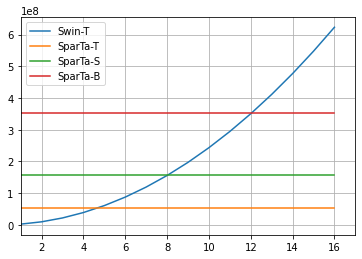

In [28]:

plt.figure(figsize=(6, 4))
plt.grid(True)
plt.plot(df['swin'], label='Swin-T')
plt.plot(df['sparta_tiny'], label='SparTa-T')
plt.plot(df['sparta_small'], label='SparTa-S')
plt.plot(df['sparta_base'], label='SparTa-B')

plt.legend()
plt.xlim(1, 17)
plt.show()